# TOI 519.01 TESS light curve analysis

**Hannu Parviainen**

**Last changed: 16.3.2020**

Here we carry out an initial TESS light curve analysis. We allow for unconstrained flux contamination to see how much a single-colour light curve can constrain it.

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import xarray as xa
import pandas as pd
from astropy.table import Table
import astropy.units as u
from numba import njit

from pytransit import BaseLPF
from pytransit.param import ParameterSet, GParameter, NormalPrior as NP, UniformPrior as UP
from pytransit.utils.eclipses import flux_ratio, reflected_fr
from pytransit.utils.misc import fold
from pytransit.lpf.tesslpf import downsample_time
from pytransit import UniformModel
%run toi_519.py

In [4]:
import pytransit.contamination as cn
from ldtk import tess

In [5]:
def calculate_beaming_alpha(teff: int = 3300):
    spfile = Path(cn.__file__).parent / 'data' / 'spectra.h5'
    spectra = pd.read_hdf(spfile)
    spectrum = spectra[teff]
    wl_nm = spectrum.index.values
    wl = wl_nm * 1e-9
    fl = spectrum.values

    b = 5 + diff(log(fl)) / diff(log(wl))
    w = tess(wl_nm)[1:] * wl[1:] * fl[1:]
    return sum(w * b) / sum(w)

In [6]:
rc('figure', figsize=(13,4))

In [7]:
times, fluxes, _, _, _, _ = read_tess(tess_file, zero_epoch, period, use_pdc=True, baseline_duration_d=period)
phase, time, flux = [], [], []
for t,f in zip(times, fluxes):
    ph = (fold(t, period.n, zero_epoch.n, 0.5) - 0.5) * period.n
    mask = abs(ph) > 0.03
    
    dt = (10 * u.min).to(u.day).value
    bt, bf, _ = downsample_time(t[mask], f[mask], dt)
    bt, bp, _ = downsample_time(t[mask], ph[mask], dt)
    m = isfinite(bt)
    
    phase.append(bp[m])
    time.append(bt[m])
    flux.append(bf[m])

In [8]:
times, fluxes, _, _, _, _ = read_tess(tess_file, zero_epoch, period, use_pdc=True, baseline_duration_d=period)
phase, time, flux = [], [], []
for t,f in zip(times, fluxes):
    ph = (fold(t, period.n, zero_epoch.n, 0.5) - 0.5) * period.n
    mask = abs(ph) > 0.03
    phase.append(ph[mask])
    time.append(t[mask])
    flux.append(f[mask])

In [9]:
from scipy.constants import c,h,k,G
@njit
def summed_planck(teff, wl, tm):
    teff = atleast_1d(teff)
    flux = zeros(teff.shape[0])
    for i in range(flux.size):
        flux[i] = sum(tm*(2*h*c**2 / wl**5 / (exp(h*c / (wl*k*teff[i])) - 1.)))
    return flux

In [10]:
#from astropy.constants import c, G
import astropy.units as u

mj2kg = u.M_jup.to(u.kg)
ms2kg = u.M_sun.to(u.kg)
d2s = u.day.to(u.s)

def boosting_amplitude(mp, ms, period, alpha):
    """
    mp: float or ndarray
        Planetary mass [MJup]
    ms: float or ndarray
        Stellar mass [MSun]
    period: float or ndarray
        Orbital period [d]
    alpha: float or ndarray
        Doppler boosting alpha [-]
    """
    return alpha / c *(2*pi*G/(d2s*period))**(1/3) * ((mp*mj2kg)/(ms*ms2kg)**(2/3))

def ev_amplitude(mp, ms, a, u=0.55, g=0.3):
    ae = 0.15 * (15 + u) * (1 + g) / (3 - g)
    return ae * (mp*mj2kg)/(ms*ms2kg) * a**-3

In [14]:
boosting_amplitude(70, 0.3, 1, 8.5)

0.0009001056470933358

In [13]:
star_m

0.369+/-0.05

In [15]:
class LPF(BaseLPF):
    
    def _post_initialisation(self):
        self.t0 = 2458491.8771169
        self.period = 1.2652328
        self.k2 = 0.3**2
        self.a = 10.
        self.phase = fold(self.timea, self.period, self.t0)
        self.em = UniformModel()
        self.em.set_data(self.timea)
        
        self._mec = self.em.evaluate(sqrt(self.k2), self.t0+0.5*self.period, self.period, self.a, 0.5*pi) - 1
        self._mec = 1 + self._mec / self._mec.ptp()
        
        self.alpha = a = 2*pi*abs(self.phase - 0.5)
        self._rff = (sin(a) + (pi-a)*cos(a))/pi * self._mec  # Reflected light
        self._dbf = sin(2*pi*self.phase)                     # Doppler boosting
        self._evf = -cos(4*pi*self.phase)                    # Ellipsoidal variations
    
        self._cwl = 1e-9*tess.wl
        self._ctm = tess.tm
    
    def _init_parameters(self):
        self.ps = ParameterSet()
        ppc = [
            GParameter('ab',  'Bond albedo',       '',       UP(0, 1),  (0,    1)),
            GParameter('mp',  'log10 planet mass', 'MJup',   UP(log10(0.1), log10(300)),  (0,    inf)),
            GParameter('ms',  'Star mass',         'MSun',   NP(1.0, 0.1), (0,    inf)),
            GParameter('teffh', 'Host effective temperature', '', UP(2000, 10000), (0, inf)),
            GParameter('teffc', 'Companion effective temperature', '', UP(500, 10000), (0, inf))]
        self.ps.add_global_block('phase_curve', ppc)
        
        pbl = [GParameter(f'c{i:02d}', f'baseline {i:02d}', '', NP(1.0, 0.005), (0, inf)) for i in range(len(self.times))]
        self.ps.add_global_block('baseline', pbl)
        self._sl_bl = self.ps.blocks[-1].slice
        self.ps.freeze()

    def emitted_flux_ratio(self, pv):
        pv = atleast_2d(pv)
        return summed_planck(pv[:,4:5], self._cwl, self._ctm) / summed_planck(pv[:,3:4], self._cwl, self._ctm)
        
    def baseline(self, pv):
        pv = atleast_2d(pv)
        return squeeze(pv[:, self._sl_bl][:, self.lcids])
    
    def emitted_light(self, pv):
        pv = atleast_2d(pv)
        return squeeze(self.emitted_flux_ratio(pv)[:,newaxis] * self.k2 * self._mec)
        
    def reflected_light(self, pv):
        pv = atleast_2d(pv)
        return squeeze(reflected_fr(self.a, pv[:,0:1])*self.k2*self._rff)
        
    def boosting(self, pv):
        pv = atleast_2d(pv)
        a = boosting_amplitude(10**pv[:,1:2], pv[:,2:3], self.period, alpha=8.5)
        return squeeze(a * self._dbf)
    
    def ellipsoidal_variation(self, pv):
        pv = atleast_2d(pv)
        a = ev_amplitude(10**pv[:,1:2], pv[:,2:3], 10, 0.55, 0.3)
        return squeeze(a * self._evf)
        
    def phase_model(self, pv):
        pv = atleast_2d(pv)
        return squeeze(self.ellipsoidal_variation(pv) + self.boosting(pv) + self.reflected_light(pv) + self.emitted_light(pv))
        
    def flux_model(self, pv):
        pv = atleast_2d(pv)
        return squeeze(self.baseline(pv) + self.phase_model(pv))
    
    def create_pv_population(self, npop: int = 50):
        return self.ps.sample_from_prior(npop)

In [16]:
lpf = LPF('toi_519_phase_model', ['TESS'], time, flux, wnids=arange(len(flux)))
lpf.set_prior('ms', 'NP', star_m.n, star_m.s)
lpf.set_prior('teffh', 'NP', 3300, 100)
lpf.set_prior('teffc', 'UP', 100, 3300)

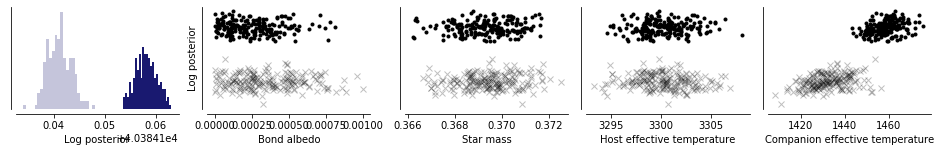

In [42]:
lpf.optimize_global(200, npop=200)

In [51]:
lpf.lnposterior(lpf.de.minimum_location)

array([40384.16309675])

In [60]:
lpf.de.minimum_location[1]

0.0024486890281064204

In [54]:
lpf.ps

[  0 |G| ab             U(a = 0, b = 1)                          [    0.00 ..     1.00],
   1 |G| mp             U(a = -1.0, b = 2.4771212547196626)      [    0.00 ..      inf],
   2 |G| ms             N(μ = 0.369, σ = 0.05)                   [    0.00 ..      inf],
   3 |G| teffh          N(μ = 3300.0, σ = 100.0)                 [    0.00 ..      inf],
   4 |G| teffc          U(a = 100, b = 3300)                     [    0.00 ..      inf],
   5 |G| c00            N(μ = 1.0, σ = 0.005)                    [    0.00 ..      inf],
   6 |G| c01            N(μ = 1.0, σ = 0.005)                    [    0.00 ..      inf],
   7 |G| c02            N(μ = 1.0, σ = 0.005)                    [    0.00 ..      inf],
   8 |G| c03            N(μ = 1.0, σ = 0.005)                    [    0.00 ..      inf],
   9 |G| c04            N(μ = 1.0, σ = 0.005)                    [    0.00 ..      inf],
  10 |G| c05            N(μ = 1.0, σ = 0.005)                    [    0.00 ..      inf],
  11 |G| c06         

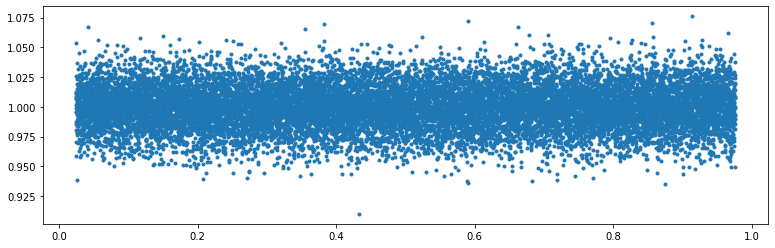

In [63]:
plot(lpf.phase, lpf.ofluxa, '.')

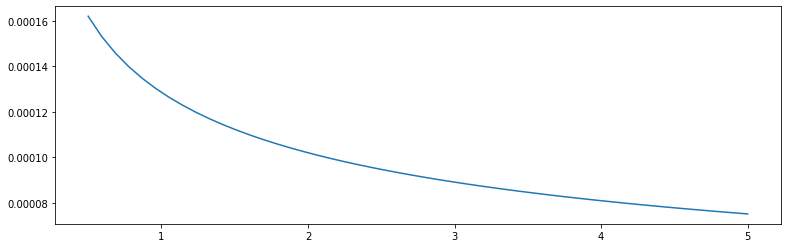

In [85]:
mps = linspace(1,100)
pers = linspace(0.5,5)
plot(pers, boosting_amplitude(10, 0.3, pers, 8.5))

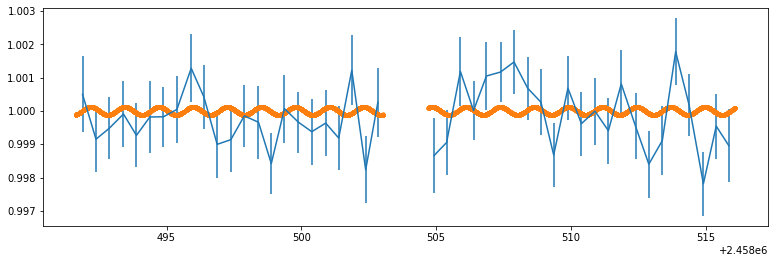

In [91]:
bt, bf, be = downsample_time(lpf.timea, lpf.ofluxa, 0.5)
errorbar(bt, bf, be)
plot(lpf.timea, 1+boosting_amplitude(10, 0.3, 1.26, 8.5)*lpf._dbf, '.')

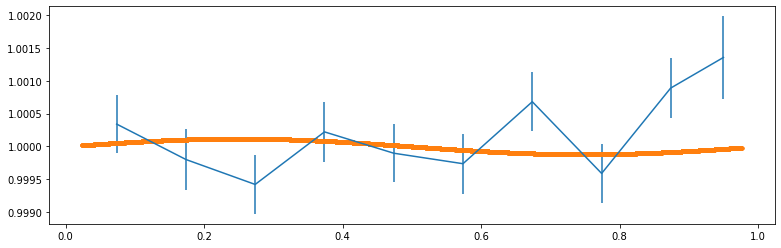

In [74]:
phasea = lpf.phase
sids = argsort(phasea)
bp, bf, be = downsample_time(phasea[sids], (lpf.ofluxa-lpf.baseline(lpf.de.minimum_location)+1)[sids], 0.1)
errorbar(bp, bf, be)
plot(lpf.phase, 1+boosting_amplitude(10, 0.3, 1.26, 8.5)*lpf._dbf, '.')

In [86]:
be


array([0.00044195, 0.00045727, 0.00044844, 0.0004586 , 0.00044527,
       0.00045839, 0.00045105, 0.00044575, 0.0004588 , 0.00062662])

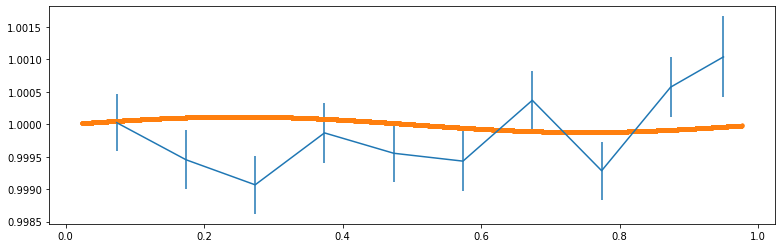

In [50]:
phasea = lpf.phase
sids = argsort(phasea)
bp, bf, be = downsample_time(phasea[sids], lpf.ofluxa[sids], 0.1)
errorbar(bp, bf, be)
plot(lpf.phase, 1+boosting_amplitude(10, 0.3, 1.26, 8.5)*lpf._dbf, '.')

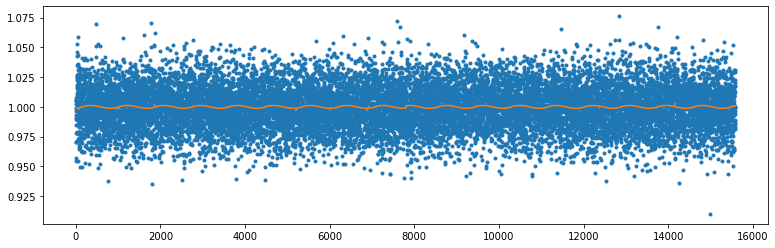

In [47]:
plot(lpf.ofluxa, '.')
#plot(lpf.baseline(lpf.de.minimum_location))
plot(1+boosting_amplitude(100, 0.3, 1.26, 8.5)*lpf._dbf, '-')

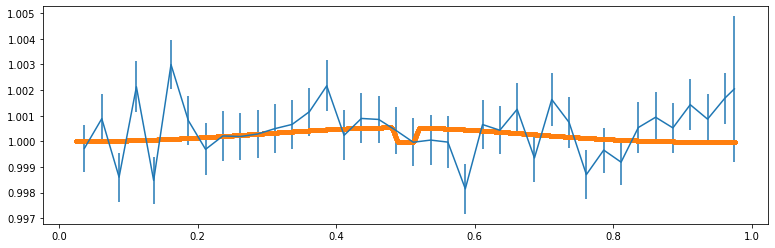

In [18]:
phasea = lpf.phase
sids = argsort(phasea)
bp, bf, be = downsample_time(phasea[sids], (lpf.ofluxa-lpf.baseline(lpf.de.minimum_location)+1)[sids], 0.025)
errorbar(bp, bf, be)
plot(phasea, 1+lpf.phase_model(lpf.de.minimum_location), '.')

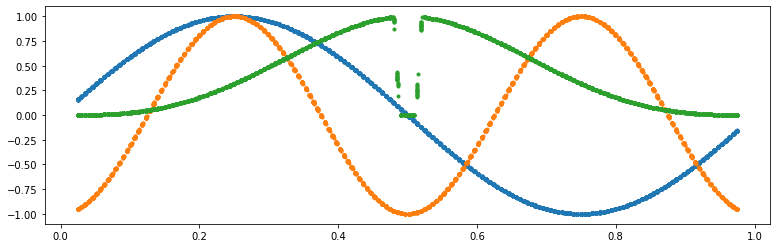

In [234]:
plot(lpf.phase, lpf._dbf, '.')
plot(lpf.phase, lpf._evf, '.')
plot(lpf.phase, lpf._rff, '.')

In [20]:
lpf.sample_mcmc(1500, thin=30, repeats=25)

In [29]:
lpf.sample_mcmc(5000, thin=50, repeats=1)

In [127]:
reflected_fr(10, 0.5)*0.3**2

0.0006749999999999999

In [30]:
df = lpf.posterior_samples(derived_parameters=False)

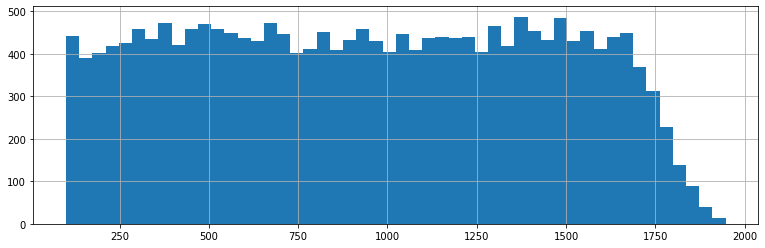

In [31]:
df.teffc.hist(bins=50)

In [37]:
percentile(df.teffc, [50, 90, 95])

array([ 945.15445027, 1620.3652761 , 1705.64079009])

In [34]:
percentile(df.ab, [50, 90, 95])

array([0.13669881, 0.38789994, 0.48434036])

In [40]:
lpf.name = "toi_519_phase_log_mp"

In [41]:
lpf.save()

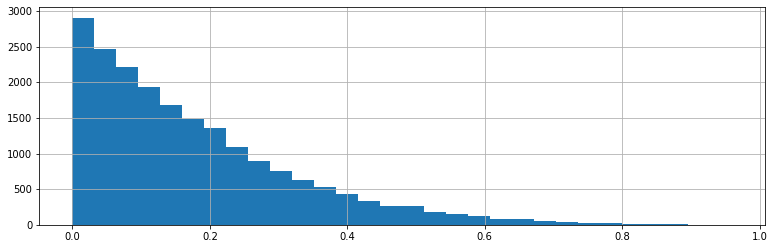

In [32]:
df.ab.hist(bins=30)

In [35]:
percentile(10**df.mp, [50, 90, 95])

array([ 2.84281535,  9.59976143, 13.15812991])

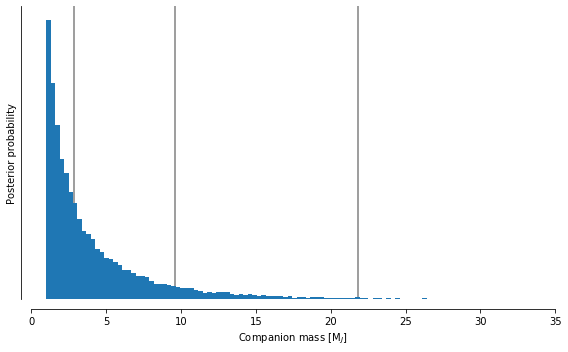

In [33]:
import seaborn as sb
fig, ax = subplots(figsize=(8,5))
hist(10**df.mp, bins=100, range=(0.1,30))
ps = [50, 90, 99]
pers = percentile(10**df.mp, ps)
[ax.axvline(v, c='k', alpha=0.5, zorder=-10) for v in pers]
#[ax.text(v, 3800, f"  P(M$_p$) $\geq$ {p:2d}%") for v,p in zip(pers,ps)]
setp(ax, xlim=(0,35), yticks=[], ylabel='Posterior probability', xlabel='Companion mass [M$_J$]')
sb.despine(fig, offset=10)
fig.tight_layout()

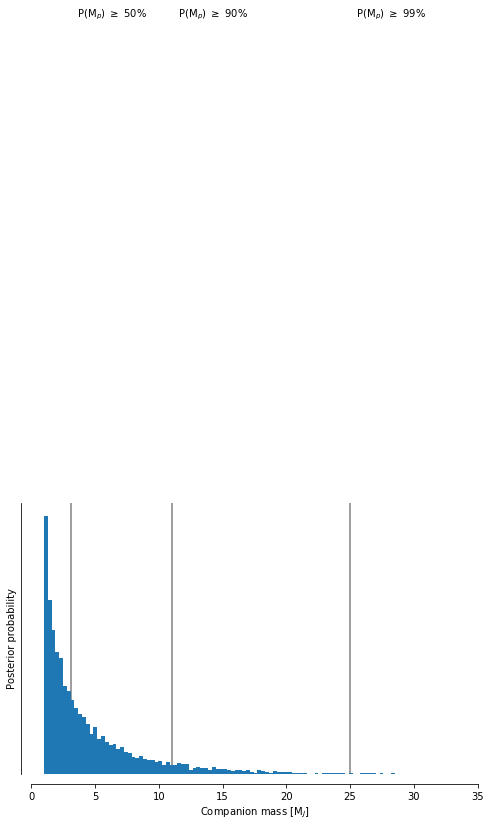

In [256]:
fig, ax = subplots(figsize=(8,5))
hist(10**df.mp, bins=100, range=(0.1,30))
ps = [50, 90, 99]
pers = percentile(10**df.mp, ps)
[ax.axvline(v, c='k', alpha=0.5, zorder=-10) for v in pers]
[ax.text(v, 3800, f"  P(M$_p$) $\geq$ {p:2d}%") for v,p in zip(pers,ps)]
setp(ax, xlim=(0,35), yticks=[], ylabel='Posterior probability', xlabel='Companion mass [M$_J$]')
sb.despine(fig, offset=10)
fig.tight_layout()
fig.savefig('toi_519_mass_from_phase_variations.pdf')

In [16]:
lpf.save()

---

<center> © 2020 Hannu Parviainen </center>